# 요약 (Summarization)

이번 튜토리얼은 문서 요약을 수행하는 방법에 대해 살펴보겠습니다.

아래는 튜토리얼의 주요 개요입니다.

- Stuff: 전체 문서 한 번에 요약
- Map-Reduce: 분할 요약 후 일괄 병합
- Map-Refine: 분할 요약 후 점진적인 병합
- Chain of Density: N번 반복 실행하며, 누락된 entity를 보완하며 요약 개선
- Clustering-Map-Refine: 문서의 Chunk 를 N 개의 클러스터로 나누고, 각 클러스터에서 중심점에 가까운 문서에 대한 요약을 Refine 요약.

## 대표적으로 알려진 요약 방식

요약기를 구축할 때 중심적인 질문은 문서를 LLM의 컨텍스트 창에 어떻게 전달할 것인가입니다. 이를 위한 몇 가지 알려진 방식은 다음과 같습니다.

1. `Stuff`: 단순히 모든 문서를 단일 프롬프트로 "넣는" 방식입니다. 이는 가장 간단한 접근 방식입니다.

2. `Map-reduce`: 각 문서를 "map" 단계에서 개별적으로 요약한 다음, "reduce" 단계에서 요약본들을 최종 요약본으로 합치는 방식입니다.

3. `Refine`: 입력 문서를 순회하며 반복적으로 답변을 업데이트하여 응답을 구성합니다. 각 문서에 대해, 모든 비문서 입력, 현재 문서, 그리고 최신 중간 답변을 chain에 전달하여 새로운 답변을 얻습니다.



In [7]:
# API KEY를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API KEY 정보로드
load_dotenv()

True

In [8]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("Summary")

LangSmith 추적을 시작합니다.
[프로젝트명]
Summary


## Stuff

`stuff documents chain`("stuff"는 "채우다" 또는 "채우기 위해"의 의미)는 문서 체인 중 가장 간단한 방식입니다. 문서 목록을 가져와서 모두 프롬프트에 삽입한 다음, 그 프롬프트를 LLM에 전달합니다.

이 체인은 문서가 작고 대부분의 호출에 몇 개만 전달되는 애플리케이션에 적합합니다.


데이터를 로드합니다.

In [9]:
from langchain_community.document_loaders import TextLoader

# 뉴스데이터 로드
loader = TextLoader("data/news.txt")
docs = loader.load()
print(f"총 글자수: {len(docs[0].page_content)}")
print("\n========= 앞부분 미리보기 =========\n")
print(docs[0].page_content[:500])

총 글자수: 1708

========= 앞부분 미리보기 =========

제목: 
AI2, 상업 활용까지 자유로운 '진짜' 오픈 소스 LLM '올모' 출시

내용:
앨런AI연구소(AI2)가 완전한 오픈 소스 대형언어모델(LLM) '올모(OLMo)’를 출시했다. 데이터 수집, 학습, 배포의 전 과정을 투명하게 공개한 데다 상업적 사용까지 허용한 진정한 의미의 오픈 소스 LLM이라는 평가다.
벤처비트는 1일(현지시간) 비영리 민간 AI 연구기관인 AI2가 ‘최초의 진정한 오픈 소스 LLM 및 프레임워크’라고 소개한 ‘올모’를 출시했다고 보도했다. 
이에 따르면 올모는 모델 코드와 모델 가중치뿐만 아니라 훈련 코드, 훈련 데이터, 관련 툴킷 및 평가 툴킷도 제공한다. 이를 통해 모델이 어떻게 구축되었는지 심층적으로 분석, LLM의 작동 방식과 응답을 생성하는 원리를 더 잘 이해할 수 있다. 
올모 프레임워크는 70억 매개변수의 ‘올모 7B’ 등 4가지 변형 모델과 10억 매개변수의 ‘올모 1B’ 모델을 제공한다. 모델들은 훈련 데이터를 생성하는 코드를 포함해 


아래는 한국어로 요약을 작성하라는 문구가 추가된 prompt 입니다.

In [10]:
from langchain import hub

prompt = hub.pull("teddynote/summary-stuff-documents-korean")
prompt.pretty_print()

Please summarize the sentence according to the following REQUEST.
REQUEST:
1. Summarize the main points in bullet points in KOREAN.
2. Each summarized sentence must start with an emoji that fits the meaning of the each sentence.
3. Use various emojis to make the summary more interesting.
4. Translate the summary into KOREAN if it is written in ENGLISH.
5. DO NOT translate any technical terms.
6. DO NOT include any unnecessary information.

CONTEXT:
{context}

SUMMARY:"



In [11]:
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_teddynote.callbacks import StreamingCallback


llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    streaming=True,
    temperature=0,
    callbacks=[StreamingCallback()],
)


stuff_chain = create_stuff_documents_chain(llm, prompt)
answer = stuff_chain.invoke({"context": docs})

- 🚀 앨런AI연구소(AI2)가 완전한 오픈 소스 LLM '올모(OLMo)'를 출시했다.  
- 📊 데이터 수집, 학습, 배포 과정을 투명하게 공개하고 상업적 사용을 허용한다.  
- 🛠️ 모델 코드, 가중치, 훈련 코드, 데이터 및 평가 툴킷을 제공하여 심층 분석이 가능하다.  
- 📈 '올모 7B'와 '올모 1B' 등 다양한 변형 모델을 포함하고 있다.  
- 🔍 훈련 데이터는 AI2의 '돌마(Dolma)' 데이터 세트를 기반으로 하며, 3조개의 토큰을 특징으로 한다.  
- 📜 아파치 2.0 라이선스에 따라 상업적 활용에 제한이 없다.  
- 💡 AI2는 연구자들이 안전하고 신뢰할 수 있는 LLM 시스템을 구축할 수 있도록 지원한다고 밝혔다.  
- 🏆 올모는 상업용 제품과 동등한 성능을 보여주며, 일부 벤치마크 테스트에서 우수한 성과를 기록했다.  
- 🌍 비영어권 언어와 코드 생성 기능에 대한 제약이 존재한다.  
- 🔄 AI2는 올모를 지속적으로 개선할 계획이다.  
- 🌐 현재 올모의 모든 리소스는 깃허브 및 허깅페이스에서 무료로 제공된다.  

## Map-Reduce

Map-reduce 방식의 요약은 긴 문서를 효율적으로 요약하는 기법입니다. 

이 방법은 먼저 문서를 작은 chunk로 나누는 "map" 단계와, 각 chunk의 요약을 결합하는 "reduce" 단계로 구성됩니다. 

1. Map 단계에서는 각 chunk를 병렬로 요약하고
2. reduce 단계에서는 이 요약들을 하나의 최종 요약으로 통합합니다. 

이 접근법은 대규모 문서를 처리할 때 특히 유용하며, 언어 모델의 토큰 제한을 우회할 수 있게 해줍니다.

![](./images/summarization_use_case_2.png)

데이터를 로드합니다.

In [12]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("data/SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()
docs = docs[3:8]  # 여기서 문서의 일부만 요약
print(f"총 페이지수: {len(docs)}")

총 페이지수: 5


### Map

map 단계에서는 각 Chunk 에 대한 요약을 생성합니다. 

(사실 정석은 Chunk 에 대한 요약 생성이지만, 저는 핵심 내용 추출로 변경하여 진행합니다. 어차피 reduce 단계에서 요약을 하나로 합치는 과정이기 때문에 상관없습니다.)

저는 이 방식이 더 유효하다고 생각하였지만, map 단계에 요약을 할지 혹은 핵심 내용을 추출할지는 본인의 판단하에 변경하여 진행할 수 있습니다.

In [104]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# map prompt 다운로드
map_prompt = hub.pull("teddynote/map-prompt")

# 프롬프트 출력
map_prompt.pretty_print()

================================ System Message ================================

You are a professional main thesis extractor.

================================ Human Message =================================

Your task is to extract main thesis from given documents. Answer should be in same language as given document. 

#Format: 
- thesis 1
- thesis 2
- thesis 3
- ...

Here is a given document: 
{doc}

Write 1~5 sentences.
#Answer:


map_chain 을 생성합니다.

In [ ]:
# map chain 생성
map_chain = map_prompt | llm | StrOutputParser()

batch() 를 호출하여 각 문서에 대한 요약본을 생성합니다.

In [14]:
# 문서에 대한 주요내용 추출
doc_summaries = map_chain.batch(docs)

In [15]:
# 요약된 문서의 수 출력
len(doc_summaries)

5

In [16]:
# 일부 문서의 요약 출력
print(doc_summaries[0])

- 미국 바이든 대통령은 안전하고 신뢰할 수 있는 AI 개발과 사용을 보장하기 위한 행정명령을 발표하였다.
- 이 행정명령은 AI의 안전과 보안 기준 마련, 개인정보 보호, 형평성과 시민권 향상, 소비자 보호, 노동자 지원, 혁신과 경쟁 촉진, 국제 협력을 포함한다.
- AI 시스템 개발 기업은 안전 테스트 결과와 시스템 정보를 미국 정부와 공유해야 하며, AI 생성 콘텐츠에 대한 표준과 모범사례를 확립해야 한다.
- 형평성과 시민권 향상을 위해 AI의 무책임한 사용으로 인한 차별과 편견을 방지하는 조치를 확대할 예정이다.
- 국가 AI 연구자원(NAIRR)을 통해 미국 전역의 AI 연구를 촉진하고, 중소기업과 개발자에게 기술과 인프라를 지원할 계획이다.


### Reduce

Reduce 단계에서는 map 단계에서 진행한 핵심 내용들을 하나의 최종 요약으로 통합합니다. 

In [103]:
# reduce prompt 다운로드
reduce_prompt = hub.pull("teddynote/reduce-prompt")

# 프롬프트 출력
reduce_prompt.pretty_print()

================================ System Message ================================

You are a professional summarizer. You are given a list of summaries of documents and you are asked to create a single summary of the documents.

================================ Human Message =================================

#Instructions: 
1. Extract main points from a list of summaries of documents
2. Make final summaries in bullet points format.
3. Answer should be written in {language}.

#Format: 
- summary 1
- summary 2
- summary 3
- ...

Here is a list of summaries of documents: 
{doc_summaries}

#SUMMARY:


Reduce Chain 을 생성합니다.

In [ ]:
# reduce chain 생성
reduce_chain = reduce_prompt | llm | StrOutputParser()

아래는 Reduce Chain 을 사용하여 스트리밍 출력 예시입니다.

In [18]:
from langchain_teddynote.messages import stream_response

answer = reduce_chain.stream({"doc_summaries": doc_summaries, "language": "Korean"})
stream_response(answer)

- 미국 바이든 대통령은 AI의 안전과 신뢰성을 보장하기 위한 행정명령을 발표하고, AI 시스템 개발 기업의 안전 테스트 결과 공유를 요구하였다.
- G7은 '히로시마 AI 프로세스'를 통해 AI 기업을 위한 국제 행동강령에 합의하고, AI 생성 콘텐츠의 신뢰성을 높이기 위한 인증 메커니즘 개발을 제안하였다.
- 28개국은 AI 안전성 정상회의에서 블레츨리 선언을 발표하고, AI 안전 연구소 출범과 안전성 시험 계획을 발표하였다.
- 미국 법원은 예술가들이 AI에 대한 저작권 침해 소송을 기각하며, 저작권 미등록 문제를 지적하였다.
- 미국 연방거래위원회(FTC)는 생성 AI의 소비자 피해 가능성과 빅테크의 시장 지배력 우려를 표명하고, 공정한 경쟁 시장 유지를 강조하였다.

In [19]:
from langchain_core.runnables import chain


@chain
def map_reduce_chain(docs):
    map_llm = ChatOpenAI(
        temperature=0,
        model_name="gpt-4o-mini",
    )

    # map prompt 다운로드
    map_prompt = hub.pull("teddynote/map-prompt")

    # map chain 생성
    map_chain = map_prompt | map_llm | StrOutputParser()

    # 첫 번째 프롬프트, ChatOpenAI, 문자열 출력 파서를 연결하여 체인을 생성합니다.
    doc_summaries = map_chain.batch(docs)

    # reduce prompt 다운로드
    reduce_prompt = hub.pull("teddynote/reduce-prompt")
    reduce_llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    reduce_chain = reduce_prompt | reduce_llm | StrOutputParser()

    return reduce_chain.invoke({"doc_summaries": doc_summaries, "language": "Korean"})

In [20]:
# 결과 출력
answer = map_reduce_chain.invoke(docs)

- 미국 바이든 대통령은 안전하고 신뢰할 수 있는 AI 개발과 사용을 보장하기 위한 행정명령을 발표하였다. 이 명령은 AI의 안전과 보안 기준 마련, 개인정보 보호, 형평성과 시민권 향상, 소비자 보호, 노동자 지원, 혁신과 경쟁 촉진, 국제 협력을 포함한다.
- G7은 '히로시마 AI 프로세스'를 통해 AI 기업을 위한 국제 행동강령에 합의하였다. 이 강령은 AI 수명주기 전반에 걸친 위험 평가와 완화, 투명성과 책임성 보장, 정보공유 및 이해관계자 간 협력을 요구한다.
- 28개국이 영국 블레츨리 파크에서 열린 AI 안전성 정상회의에서 AI 안전 보장을 위한 협력 방안을 담은 블레츨리 선언을 발표했다. 선언은 AI 시스템의 안전을 보장하기 위해 모든 이해관계자의 협력이 중요하다고 강조하며, 첨단 AI 개발 기업의 책임을 지적했다.
- 미국 캘리포니아 북부지방법원은 예술가들이 생성 AI 기업에 제기한 저작권 침해 소송을 기각하였다. 기각 사유로는 고소장에 제시된 작품들이 저작권청에 등록되지 않았고, AI로 생성된 이미지와 특정 작품 간의 유사성을 입증하기 어렵다는 점이 있었다.
- 미국 연방거래위원회(FTC)는 생성 AI로 인한 소비자와 창작자의 피해 가능성 및 빅테크의 시장 지배력 강화 우려를 표명했다. FTC는 생성 AI의 개발과 배포가 소비자 개인정보 침해, 차별과 편견의 자동화, 사기 범죄 등 다양한 위험을 초래할 수 있다고 경고했다.

## Map-Refine

Map-refine 방식은 문서 요약을 위한 또 다른 접근법으로, map-reduce와 유사하지만 약간의 차이가 있습니다. 

1. Map 단계: 문서를 여러 개의 작은 chunk로 나누고, 각 chunk에 대해 개별적으로 요약을 생성합니다.

2. Refine 단계: 생성된 요약들을 순차적으로 처리하며 최종 요약을 점진적으로 개선합니다. 각 단계에서 이전 요약과 새로운 chunk의 정보를 결합하여 요약을 갱신합니다.
   
3. 반복 과정: 모든 chunk가 처리될 때까지 refine 단계를 반복합니다.

4. 최종 요약: 마지막 chunk까지 처리한 후 얻은 요약이 최종 결과가 됩니다.

map-refine 방식의 장점은 문서의 순서를 유지하면서 점진적으로 요약을 개선할 수 있다는 것입니다. 이는 특히 문서의 맥락이 중요한 경우에 유용할 수 있습니다. 그러나 이 방식은 map-reduce 에 비해 순차적으로 처리되기 때문에 병렬화가 어려워 대규모 문서 처리 시 시간이 더 오래 걸릴 수 있습니다.

![](./images/summarization_use_case_3.png)

### Map

map 단계에서는 각 Chunk 에 대한 요약을 생성합니다. 

In [105]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# map llm 생성
map_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# map chain 생성
map_summary = hub.pull("teddynote/map-summary-prompt")

# 프롬프트 출력
map_summary.pretty_print()

================================ System Message ================================

You are an expert summarizer. Your task is to summarize the following document in {language}.

================================ Human Message =================================

Extract most important main thesis from the documents, then summarize in bullet points.

#Format:
- summary 1
- summary 2
- summary 3
-...

Here is a given document: 
{documents}

Write 1~5 sentences. Think step by step.
#Summary:


map_chain 을 생성합니다.

In [ ]:
# map chain 생성
map_chain = map_summary | llm | StrOutputParser()

첫 번째 문서에 대한 요약본을 출력합니다.

In [22]:
# 첫 번째 문서의 요약 출력
print(map_chain.invoke({"documents": docs[0], "language": "Korean"}))

- 미국 바이든 대통령이 안전하고 신뢰할 수 있는 AI 개발과 사용을 위한 행정명령을 발표하였다.
- 행정명령은 AI의 안전과 보안 기준, 개인정보 보호, 형평성과 시민권 향상, 소비자 보호, 노동자 지원, 혁신과 경쟁 촉진, 국제 협력을 포함한다.
- AI 시스템 개발 기업은 안전 테스트 결과와 시스템 정보를 정부와 공유해야 하며, AI 생성 콘텐츠에 대한 표준과 모범사례를 확립할 예정이다.
- 형평성과 시민권 향상을 위해 AI의 무책임한 사용으로 인한 차별을 방지하는 조치를 확대하고, 소비자 보호와 근로자 지원을 위한 원칙과 모범사례를 마련한다.
- 국가 AI 연구자원(NAIRR)을 통해 AI 연구를 촉진하고, 외국인 전문가들이 미국에서 공부하고 취업할 수 있도록 지원할 계획이다.


In [23]:
# 모든 문서를 입력으로 정의합니다.
input_doc = [{"documents": doc, "language": "Korean"} for doc in docs]

In [24]:
# 모든 문서에 대한 요약본을 출력합니다.
print(map_chain.batch(input_doc))

['- 미국 바이든 대통령이 안전하고 신뢰할 수 있는 AI 개발과 사용을 위한 행정명령을 발표하였다.\n- 행정명령은 AI의 안전과 보안 기준, 개인정보 보호, 형평성과 시민권 향상, 소비자 보호, 노동자 지원, 혁신과 경쟁 촉진, 국제 협력을 포함한다.\n- AI 시스템 개발 기업은 안전 테스트 결과와 시스템 정보를 정부와 공유해야 하며, AI 생성 콘텐츠에 대한 표준과 모범사례를 확립할 예정이다.\n- 형평성과 시민권 향상을 위해 AI의 무책임한 사용으로 인한 차별을 방지하는 조치를 확대하고, 소비자 보호와 근로자 지원을 위한 원칙과 모범사례를 마련한다.\n- 국가 AI 연구자원(NAIRR)을 통해 AI 연구를 촉진하고, 외국인 전문가들이 미국에서 공부하고 취업할 수 있도록 지원할 계획이다.', "- G7은 2023년 10월 30일 '히로시마 AI 프로세스'를 통해 AI 기업을 위한 국제 행동강령에 합의하였다.\n- 이 행동강령은 AI 시스템의 위험 식별과 완화를 위한 자발적인 채택을 권장하며, AI 수명주기 전반에 걸친 위험 평가와 투명성, 책임성을 강조한다.\n- 주요 내용으로는 정보 공유, 협력, 보안 통제, 콘텐츠 인증 및 출처 확인 등이 포함되어 있다.\n- G7은 AI 기술의 빠른 발전에 대응하기 위해 이해관계자 협의를 통해 행동강령을 필요에 따라 개정할 예정이다.\n- 또한, 사회적 위험 완화와 세계적 난제 해결을 위한 AI 시스템 개발을 우선시하고, 개인정보 보호를 위한 적절한 보호 장치를 구현할 계획이다.", "- 28개국이 영국 블레츨리 파크에서 열린 AI 안전성 정상회의에서 AI 위험에 공동 대응하기 위한 '블레츨리 선언'을 발표했다.\n- 선언은 AI 시스템의 안전 보장을 위해 모든 이해관계자의 협력이 중요하다고 강조하며, 특히 AI 개발 기업의 안전 평가 책임을 지적했다.\n- 영국 총리는 AI 안전 연구소의 출범과 함께 첨단 AI 모델에 대한 안전성 시험 계획을 발표하고, 각국 정부는 테스트 결과를 공유하고 공동 표준 개발에 노력하

### Refine

Refine 단계에서는 이전의 map 단계에서 생성한 chunk들을 순차적으로 처리하며 최종 요약을 점진적으로 개선합니다. 

In [106]:
# refine prompt 다운로드
refine_prompt = hub.pull("teddynote/refine-prompt")

# 프롬프트 출력
refine_prompt.pretty_print()

================================ System Message ================================

You are an expert summarizer.

================================ Human Message =================================

Your job is to produce a final summary

We have provided an existing summary up to a certain point:
{previous_summary}

We have the opportunity to refine the existing summary(only if needed) with some more context below.
------------
{current_summary}
------------
Given the new context, refine the original summary in {language}.
If the context isn't useful, return the original summary.


In [ ]:
# refine llm 생성
refine_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# refine chain 생성
refine_chain = refine_prompt | refine_llm | StrOutputParser()

아래는 map_reduce_chain 을 생성하는 예시입니다. 

지금까지의 일련의 과정을 하나의 chain 으로 엮습니다.

In [26]:
from langchain_core.runnables import chain


@chain
def map_refine_chain(docs):

    # map chain 생성
    map_summary = hub.pull("teddynote/map-summary-prompt")

    map_chain = (
        map_summary
        | ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,
        )
        | StrOutputParser()
    )

    input_doc = [{"documents": doc.page_content, "language": "Korean"} for doc in docs]

    # 첫 번째 프롬프트, ChatOpenAI, 문자열 출력 파서를 연결하여 체인을 생성합니다.
    doc_summaries = map_chain.batch(input_doc)

    refine_prompt = hub.pull("teddynote/refine-prompt")

    refine_llm = ChatOpenAI(
        model_name="gpt-4o-mini",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    refine_chain = refine_prompt | refine_llm | StrOutputParser()

    previous_summary = doc_summaries[0]

    for current_summary in doc_summaries[1:]:

        previous_summary = refine_chain.invoke(
            {
                "previous_summary": previous_summary,
                "current_summary": current_summary,
                "language": "Korean",
            }
        )
        print("\n\n-----------------\n\n")

    return previous_summary

In [27]:
refined_summary = map_refine_chain.invoke(docs)

- 미국 바이든 대통령이 안전하고 신뢰할 수 있는 AI 개발과 사용을 위한 행정명령을 발표하였다.
- 이 행정명령은 AI의 안전과 보안 기준, 개인정보 보호, 형평성과 시민권 향상, 소비자 보호, 노동자 지원, 혁신과 경쟁 촉진, 국제 협력을 포함한다.
- AI 시스템 개발 기업은 안전 테스트 결과와 시스템 정보를 미국 정부와 공유해야 하며, AI의 책임 있는 사용을 위한 법적 지침이 마련된다.
- 소비자 보호와 근로자 지원을 위해 의료 분야에서의 AI 사용 촉진 및 교육 도구 개발이 강조된다.
- 국가 AI 연구자원(NAIRR)을 통해 AI 연구를 촉진하고, 외국인 전문가들이 미국에서 공부하고 취업할 수 있도록 지원하는 방안도 포함된다.
- 또한, G7은 '히로시마 AI 프로세스'를 통해 AI 기업을 위한 국제 행동강령에 합의하였으며, 이는 AI 시스템의 위험 식별과 완화를 위한 자발적인 채택을 권장하고, AI 수명주기 전반에 걸친 위험 평가와 투명성, 책임성을 강조한다. 
- G7은 기술 발전에 대응하기 위해 이해관계자 협의를 통해 행동강령을 개정할 계획이며, 사회적 위험 완화와 개인정보 보호를 위한 적절한 장치 구현을 우선시하고 있다.

-----------------


- 미국 바이든 대통령이 안전하고 신뢰할 수 있는 AI 개발과 사용을 위한 행정명령을 발표하였다.
- 이 행정명령은 AI의 안전과 보안 기준, 개인정보 보호, 형평성과 시민권 향상, 소비자 보호, 노동자 지원, 혁신과 경쟁 촉진, 국제 협력을 포함한다.
- AI 시스템 개발 기업은 안전 테스트 결과와 시스템 정보를 미국 정부와 공유해야 하며, AI의 책임 있는 사용을 위한 법적 지침이 마련된다.
- 소비자 보호와 근로자 지원을 위해 의료 분야에서의 AI 사용 촉진 및 교육 도구 개발이 강조된다.
- 국가 AI 연구자원(NAIRR)을 통해 AI 연구를 촉진하고, 외국인 전문가들이 미국에서 공부하고 취업할 수 있도록 지원하는 방안도 포함된다.
- G7은 '히로시마 AI 프로세스'를 통해 A

## Chain of Density

- 논문: https://arxiv.org/pdf/2309.04269

"Chain of Density" (CoD) 프롬프트는 GPT-4를 사용한 요약 생성을 개선하기 위해 개발된 기법입니다. 

이 방법은 초기에 개체가 적은 요약을 생성한 후, 길이를 늘리지 않으면서 누락된 중요 개체들을 반복적으로 통합하는 과정을 거칩니다. 연구 결과, CoD로 생성된 요약은 일반 프롬프트보다 더 추상적이고 정보 융합이 뛰어나며, 인간이 작성한 요약과 비슷한 밀도를 가진 것으로 나타났습니다.

1. 점진적 개선: CoD는 초기에 개체가 적은 간단한 요약을 생성한 후, 단계적으로 중요한 개체들을 추가하며 요약을 개선합니다. 이 과정에서 요약의 길이는 유지되면서 정보 밀도가 증가하여 읽기 쉬우면서도 정보량이 풍부한 요약이 만들어집니다.

2. 정보 밀도와 가독성의 균형: CoD 방식은 요약의 정보 밀도를 조절하여 정보성과 가독성 사이의 최적 균형점을 찾습니다. 연구 결과에 따르면, 사람들은 일반적인 GPT-4 요약보다 더 밀도 있지만 사람이 작성한 요약만큼 밀도가 높지 않은 CoD 요약을 선호하는 것으로 나타났습니다.

3. 추상화와 정보 융합 개선: CoD로 생성된 요약은 더 추상적이고 정보 융합이 뛰어나며, 원문의 앞부분에 치우치는 경향(lead bias)이 덜합니다. 이는 요약의 전반적인 품질과 가독성을 향상시키는 데 기여합니다.

[Chain of Density Prompt](https://smith.langchain.com/prompts/chain-of-density-prompt/4582aae0?organizationId=8c9eeb3c-2665-5405-bc50-0767fdf4ca8f)

**입력 파라미터 설명**

- `content_category`: 콘텐츠 정류(예: 기사, 동영상 녹취록, 블로그 게시물, 연구 논문). 기본값: Article

- `content`: 요약할 콘텐츠

- `entity_range`: 콘텐츠에서 선택하여 요약에 추가할 엔티티의 수의 범위. 기본값은 `1-3`

- `max_words`: 1번 요약시, 요약에 포함할 최대 단어. 기본값은 **80** 입니다.

- `iterations`: 엔티티 고밀도화 라운드 수. 총 요약은 **반복 횟수+1** 입니다. 80단어의 경우 3회 반복이 이상적입니다. 요약이 더 길면 4~5회, 그리고 `entity_range` 를 예를 들어 1~4로 변경하는 것도 도움이 될 수 있습니다. 기본값: 3.

이 코드는 Chain of Density 프롬프트를 사용하여 텍스트 요약을 생성하는 체인을 구성합니다.

첫 번째 체인은 중간 결과를 보여주고, 두 번째 체인은 최종 요약만을 추출합니다.

In [28]:
import textwrap
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import SimpleJsonOutputParser

# {content}를 제외한 모든 입력에 대한 기본값 지정
cod_chain_inputs = {
    "content": lambda d: d.get("content"),
    "content_category": lambda d: d.get("content_category", "Article"),
    "entity_range": lambda d: d.get("entity_range", "1-3"),
    "max_words": lambda d: int(d.get("max_words", 80)),
    "iterations": lambda d: int(d.get("iterations", 5)),
}

# Chain of Density 프롬프트 다운로드
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

# Chain of Density 체인 생성
cod_chain = (
    cod_chain_inputs
    | cod_prompt
    | ChatOpenAI(temperature=0, model="gpt-4o-mini")
    | SimpleJsonOutputParser()
)

# 두 번째 체인 생성, 최종 요약만 추출 (스트리밍 불가능, 최종 결과가 필요함)
cod_final_summary_chain = cod_chain | (
    lambda output: output[-1].get(
        "denser_summary", '오류: 마지막 딕셔너리에 "denser_summary" 키가 없습니다'
    )
)

요약할 데이터를 확인합니다.

In [42]:
content = docs[1].page_content
print(content)

SPRi AI Brief |  
2023-12 월호
2G7, 히로시마 AI 프로세스를 통해 AI 기업 대상 국제 행동강령에 합의
nG7이 첨단 AI 시스템을 개발하는 기업을 대상으로 AI 위험 식별과 완화를 위해 자발적인 
채택을 권고하는 AI 국제 행동강령을 마련
n행동강령은 AI 수명주기 전반에 걸친 위험 평가와 완화, 투명성과 책임성의 보장, 정보공유와 
이해관계자 간 협력, 보안 통제, 콘텐츠 인증과 출처 확인 등의 조치를 요구KEY Contents
£G7, 첨단 AI 시스템의 위험 관리를 위한 국제 행동강령 마련
n주요 7개국(G7)* 은 2023 년 10월 30일 ‘히로시마 AI 프로세스 ’를 통해 AI 기업 대상의 AI 국제 
행동강령 (International Code of Conduct for Advanced AI Systems) 에 합의
∙G7은 2023 년 5월 일본 히로시마에서 개최된 정상회의에서 생성 AI에 관한 국제규범 마련과 
정보공유를 위해 ‘히로시마 AI 프로세스 ’를 출범**
∙기업의 자발적 채택을 위해 마련된 이번 행동강령은 기반모델과 생성 AI를 포함한 첨단 AI 시스템의 
위험 식별과 완화에 필요한 조치를 포함
* 주요 7개국(G7)은 미국, 일본, 독일, 영국, 프랑스 , 이탈리아 , 캐나다를 의미
** 5월 정상회의에는 한국, 호주, 베트남 등을 포함한 8개국이 초청을 받았으나 , AI 국제 행동강령에는 우선 G7 국가만 포함하여 채택
nG7은 행동강령을 통해 아래의 조치를 제시했으며 , 빠르게 발전하는 기술에 대응할 수 있도록 
이해관계자 협의를 통해 필요에 따라 개정할 예정
∙첨단 AI 시스템의 개발 과정에서 AI 수명주기 전반에 걸쳐 위험을 평가 및 완화하는 조치를 채택하고 , 
첨단 AI 시스템의 출시와 배포 이후 취약점과 오용 사고, 오용 유형을 파악해 완화
∙첨단 AI 시스템의 성능과 한계를 공개하고 적절하거나 부적절한 사용영역을 알리는 방법으로 투명성을 
보장하고 책임성을 강화
∙산업계 , 정부, 시민사회 

부분 JSON 스트리밍하기. 스트리밍된 각 청크는 새로운 접미사가 추가된 동일한 JSON 딕트 목록입니다. 

따라서 단순히 연결하는 것이 아니라 다음 청크가 이전 청크를 덮어쓰고 반복적으로 스트리밍을 추가하는 것처럼 보이게 하려면 `\r` 캐리지 리턴 인쇄가 필요합니다.

In [43]:
# 결과를 저장할 빈 리스트 초기화
results: list[dict[str, str]] = []

# cod_chain을 스트리밍 모드로 실행하고 부분적인 JSON 결과를 처리
for partial_json in cod_chain.stream(
    {"content": content, "content_category": "Article"}
):
    # 각 반복마다 results를 업데이트
    results = partial_json

    # 현재 결과를 같은 줄에 출력 (캐리지 리턴을 사용하여 이전 출력을 덮어씀)
    print(results, end="\r", flush=True)

# 총 요약 수 계산
total_summaries = len(results)
print("\n")

# 각 요약을 순회하며 처리
i = 1
for cod in results:
    # 누락된 엔티티들을 추출하고 포맷팅
    added_entities = ", ".join(
        [
            ent.strip()
            for ent in cod.get(
                "missing_entities", 'ERR: "missing_entiies" key not found'
            ).split(";")
        ]
    )
    # 더 밀도 있는 요약 추출
    summary = cod.get("denser_summary", 'ERR: missing key "denser_summary"')

    # 요약 정보 출력 (번호, 총 개수, 추가된 엔티티)
    print(
        f"### CoD Summary {i}/{total_summaries}, 추가된 엔티티(entity): {added_entities}"
        + "\n"
    )
    # 요약 내용을 80자 너비로 줄바꿈하여 출력
    print(textwrap.fill(summary, width=80) + "\n")
    i += 1

print("\n============== [최종 요약] =================\n")
print(summary)

[{'missing_entities': 'AI 국제 행동강령;히로시마 AI 프로세스;G7 국가', 'denser_summary': '2023년 10월 30일, G7 국가들은 히로시마 AI 프로세스를 통해 AI 기업을 위한 AI 국제 행동강령에 합의했다. 이 행동강령은 AI 위험 식별과 완화를 위한 자발적 채택을 권장하며, AI 수명주기 전반의 위험 평가, 투명성, 책임성, 정보 공유 및 보안 통제를 요구한다.'}, {'missing_entities': '위험 평가;정보 공유;AI 거버넌스', 'denser_summary': '2023년 10월 30일, G7 국가들은 히로시마 AI 프로세스를 통해 AI 기업을 위한 AI 국제 행동강령에 합의했다. 이 행동강령은 AI 위험 식별과 완화를 위한 자발적 채택을 권장하며, 위험 평가, 정보 공유, AI 거버넌스 및 보안 통제를 요구한다.'}, {'missing_entities': 'AI 수명주기;투명성;신뢰할 수 있는 콘텐츠', 'denser_summary': '2023년 10월 30일, G7 국가들은 히로시마 AI 프로세스를 통해 AI 기업을 위한 AI 국제 행동강령에 합의했다. 이 행동강령은 AI 수명주기 전반의 위험 평가, 투명성 보장, 신뢰할 수 있는 콘텐츠 인증 및 정보 공유를 요구한다.'}, {'missing_entities': '강력한 보안 통제;사회적 위험;기후 위기 대응', 'denser_summary': '2023년 10월 30일, G7 국가들은 히로시마 AI 프로세스를 통해 AI 기업을 위한 AI 국제 행동강령에 합의했다. 이 행동강령은 AI 수명주기 전반의 위험 평가, 강력한 보안 통제, 사회적 위험 완화 및 기후 위기 대응을 요구한다.'}, {'missing_entities': 'AI 생성 콘텐츠;위험 기반 접근;국제 기술 표준', 'denser_summary': '2023년 10월 30일, G7 국가들은 히로시마 AI 프로세스를 통해 AI 기업을 위한 AI 국제 행동강령에 합의했다. 이 행동강령

In [45]:
print(summary)

2023년 10월 30일, G7 국가들은 히로시마 AI 프로세스를 통해 AI 기업을 위한 AI 국제 행동강령에 합의했다. 이 행동강령은 AI 생성 콘텐츠 식별, 위험 기반 접근, 국제 기술 표준 개발 및 AI 수명주기 전반의 위험 평가를 요구한다.


## Clustering-Map-Refine

이 튜토리얼의 원 저자인 gkamradt 은 긴 문서의 요약에 대해서 흥미로운 제안을 하였습니다.

배경은 다음과 같습니다.

1. map-reduce 나 map-refine 방식은 모두 시간이 오래 걸리고, 비용이 많이 듬.
2. 따라서, 문서를 몇 개(N 개)의 클러스터로 나눈 뒤, 가장 중심축에서 가까운 문서를 클러스터의 대표 문서로 인지하고, 이를 map-reduce(혹은 map-refine) 방식으로 요약하는 방식을 제안.

실제로 비용도 합리적으로, 결과도 만족스럽기 때문에 원 저자의 튜토리얼의 코드를 수정하여 공유합니다.

- [원 저자 및 출처 - gkamradt](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/5%20Levels%20Of%20Summarization%20-%20Novice%20To%20Expert.ipynb)

In [51]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyMuPDFLoader("data/SPRI_AI_Brief_2023년12월호_F.pdf")
docs = loader.load()
len(docs)

23

아래의 코드를 실행하면 하나의 문서로 텍스트를 합칩니다. 합치는 목적은 page 별로 구분하지 않기 위해서입니다.

합쳐진 문자수는 약 28K 입니다.

In [53]:
# 하나의 Text 로 모든 문서를 연결합니다.
texts = "\n\n".join([doc.page_content for doc in docs])
len(texts)

28086

`RecursiveCharacterTextSplitter` 를 사용하여 하나의 Text 를 여러 문서로 나눕니다.

In [63]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
split_docs = text_splitter.split_text(texts)

나누어진 문서의 수를 확인합니다. 여기서는 79개의 문서로 나누었습니다.

In [64]:
# 총 문서의 수 확인
len(split_docs)

79

Upstage Embeddings 모델을 사용하여 문서를 임베딩합니다.

In [70]:
from langchain_upstage import UpstageEmbeddings

embeddings = UpstageEmbeddings(model="solar-embedding-1-large-passage")

vectors = embeddings.embed_documents(split_docs)

총 79개의 문서를 10개 클러스터로 나눕니다. 이때 `KMeans` 를 사용하여 클러스터링을 수행합니다.

In [71]:
from sklearn.cluster import KMeans

# 클러스터 수를 선택하면 문서의 콘텐츠에 따라 조정할 수 있습니다.
num_clusters = 10

# Perform K-means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=123).fit(vectors)

라벨링 된 결과를 확인합니다.

In [72]:
# 결과 확인
kmeans.labels_

array([5, 3, 7, 6, 4, 4, 4, 5, 3, 8, 8, 8, 1, 1, 8, 1, 1, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 3, 7, 7, 7, 7, 8, 8, 8, 8, 2, 2, 2, 2, 9, 9, 9, 3,
       9, 9, 9, 6, 6, 6, 6, 5, 5, 5, 5, 0, 0, 0, 0, 4, 4, 4, 8, 8, 8, 8,
       4, 8, 4, 9, 4, 4, 9, 6, 2, 5, 4, 4, 4], dtype=int32)

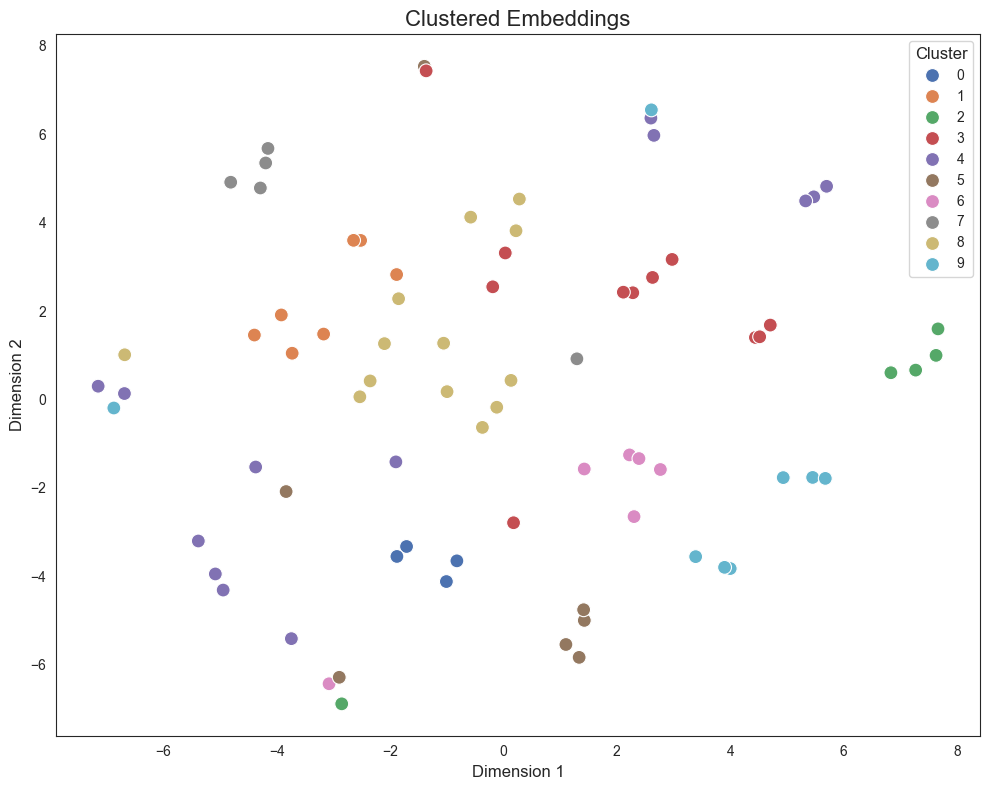

In [100]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 제거
import warnings

warnings.filterwarnings("ignore")

# t-SNE 수행 및 2차원으로 축소
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# seaborn 스타일 설정
sns.set_style("white")

# 축소된 데이터 플롯
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data_tsne[:, 0],
    y=reduced_data_tsne[:, 1],
    hue=kmeans.labels_,
    palette="deep",
    s=100,
)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.title("Clustered Embeddings", fontsize=16)
plt.legend(title="Cluster", title_fontsize=12)

# 배경색 설정
plt.gcf().patch.set_facecolor("white")

plt.tight_layout()
plt.show()

그러면 각 cluster 의 중심점에 가장 가까운 임베딩을 찾아서 저장해야 합니다.

In [87]:
import numpy as np

# 가장 가까운 점들을 저장할 빈 리스트 생성
closest_indices = []

# 클러스터 수만큼 반복
for i in range(num_clusters):

    # 해당 클러스터 중심으로부터의 거리 목록 구하기
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

    # 가장 가까운 점의 인덱스 찾기 (argmin을 사용하여 최소 거리 찾기)
    closest_index = np.argmin(distances)

    # 해당 인덱스를 가장 가까운 인덱스 리스트에 추가
    closest_indices.append(closest_index)

문서의 요약을 순서대로 진행하기 위하여 오름차순 정렬합니다.

In [85]:
# 문서의 요약을 순서대로 진행하기 위하여 오름차순 정렬
selected_indices = sorted(closest_indices)
selected_indices

[4, 16, 24, 28, 34, 37, 41, 47, 51, 55]

10개의 선택된 문서를 출력합니다. 이 과정에서 `Document` 객체를 사용하여 문서를 생성합니다.

In [84]:
from langchain_core.documents import Document

selected_docs = [Document(page_content=split_docs[doc]) for doc in selected_indices]
selected_docs

[Document(page_content='▹ 빌 게이츠, AI 에이전트로 인한 컴퓨터 사용의 패러다임 변화 전망································ 13\n   ▹ 유튜브, 2024년부터 AI 생성 콘텐츠 표시 의무화···························································· 14\n 3. 기술/연구\n   ▹ 영국 과학혁신기술부, AI 안전 연구소 설립 발표······························································ 15\n   ▹ 구글 딥마인드, 범용 AI 모델의 기능과 동작에 대한 분류 체계 발표······························ 16\n   ▹ 갈릴레오의 LLM 환각 지수 평가에서 GPT-4가 가장 우수 ··········································· 17\n   \n 4. 인력/교육'),
 Document(page_content='1. 정책/법제  \n2. 기업/산업 \n3. 기술/연구 \n 4. 인력/교육\n영국 AI 안전성 정상회의에 참가한 28개국, AI 위험에 공동 대응 선언\nn 영국 블레츨리 파크에서 개최된 AI 안전성 정상회의에 참가한 28개국들이 AI 안전 보장을 \n위한 협력 방안을 담은 블레츨리 선언을 발표\nn 첨단 AI를 개발하는 국가와 기업들은 AI 시스템에 대한 안전 테스트 계획에 합의했으며, \n영국의 AI 안전 연구소가 전 세계 국가와 협력해 테스트를 주도할 예정 \nKEY Contents\n£ AI 안전성 정상회의 참가국들, 블레츨리 선언 통해 AI 안전 보장을 위한 협력에 합의\nn 2023년 11월 1~2일 영국 블레츨리 파크에서 열린 AI 안전성 정상회의(AI Safety Summit)에 \n참가한 28개국 대표들이 AI 위험 관리를 위한 ‘블레츨리 선언’을 발표 \n∙선언은 AI 안전 보장을 위해 국가, 국제기구, 기업, 시민사회, 학계를 포함

In [82]:
# 이전에 생성한 map_refine_chain을 사용하여 요약 생성
refined_summary = map_refine_chain.invoke(selected_docs)

- 빌 게이츠는 AI 에이전트가 컴퓨터 사용 방식에 큰 변화를 가져올 것이라고 전망했다.
- 유튜브는 2024년부터 AI가 생성한 콘텐츠에 대한 표시를 의무화할 계획이다.
- 영국 과학혁신기술부는 AI 안전 연구소를 설립한다고 발표했다.
- 28개국이 참가한 영국 AI 안전성 정상회의에서 AI 안전 보장을 위한 블레츨리 선언이 발표되었으며, 이는 AI 위험 관리를 위해 모든 이해관계자의 협력을 강조하고 있다.
- 첨단 AI 개발 국가와 기업들은 AI 시스템에 대한 안전 테스트 계획에 합의하였고, 영국의 AI 안전 연구소가 이를 주도할 예정이다.
- 구글 딥마인드는 범용 AI 모델의 기능과 동작에 대한 새로운 분류 체계를 발표했다.
- 갈릴레오의 연구에서 GPT-4가 LLM 환각 지수 평가에서 가장 우수한 성과를 보였다.

-----------------


- 빌 게이츠는 AI 에이전트가 컴퓨터 사용 방식에 큰 변화를 가져올 것이라고 전망했다.
- 유튜브는 2024년부터 AI가 생성한 콘텐츠에 대한 표시를 의무화할 계획이다.
- 영국 과학혁신기술부는 AI 안전 연구소를 설립한다고 발표했다.
- 28개국이 참가한 영국 AI 안전성 정상회의에서 AI 안전 보장을 위한 블레츨리 선언이 발표되었으며, 이는 AI 위험 관리를 위해 모든 이해관계자의 협력을 강조하고 있다.
- 첨단 AI 개발 국가와 기업들은 AI 시스템에 대한 안전 테스트 계획에 합의하였고, 영국의 AI 안전 연구소가 이를 주도할 예정이다.
- 구글 딥마인드는 범용 AI 모델의 기능과 동작에 대한 새로운 분류 체계를 발표했다.
- 갈릴레오의 연구에서 GPT-4가 LLM 환각 지수 평가에서 가장 우수한 성과를 보였다.
- 미국 연방거래위원회(FTC)는 저작권청에 AI와 관련된 소비자 보호 및 경쟁 측면의 의견서를 제출하며, 생성 AI로 인해 창작자와 소비자가 피해를 입을 가능성에 대해 우려를 표명했다.
- FTC는 일부 대형 기술 기업들이 막대한 자원을 통해 시장 지배력을 강화할 수 있다는 점에 대한 우려

In [83]:
# 최종 결과 출력
print(refined_summary)

- 빌 게이츠는 5년 내에 일상 언어로 모든 작업을 처리할 수 있는 AI 에이전트가 보급될 것이라고 전망하며, 이러한 AI 에이전트가 컴퓨터 사용 방식을 완전히 변화시키고 소프트웨어 산업에도 큰 영향을 미칠 것으로 예상하고 있다. AI 에이전트의 도입은 의료, 교육, 생산성, 엔터테인먼트 및 쇼핑 등 다양한 산업 분야에서 고가의 서비스가 대중화되는 계기가 될 것이다.
- 유튜브는 2024년부터 AI가 생성한 콘텐츠에 대한 표시를 의무화할 계획이다.
- 영국 과학혁신기술부는 AI 안전 연구소를 설립한다고 발표했다.
- 28개국이 참가한 영국 AI 안전성 정상회의에서 AI 안전 보장을 위한 블레츨리 선언이 발표되었으며, 이는 AI 위험 관리를 위해 모든 이해관계자의 협력을 강조하고 있다.
- 첨단 AI 개발 국가와 기업들은 AI 시스템에 대한 안전 테스트 계획에 합의하였고, 영국의 AI 안전 연구소가 이를 주도할 예정이다.
- AI 안전 기금을 통해 외부 연구집단의 AI 시스템 평가에 자금을 지원할 계획이며, AI 레드팀을 위한 새로운 모델 평가 기법 개발이 중점적으로 지원될 예정이다.
- AI 레드팀에 대한 자금 지원은 AI 모델의 안전과 보안 기준 개선에 기여할 것으로 예상되며, 포럼은 향후 몇 달 내에 기금 지원을 위한 제안 요청을 받을 계획이다.
- 또한, 첨단 AI 모델의 취약점 및 위험 완화 정보를 공유할 수 있는 공개 절차도 개발 중이다.
- 구글 딥마인드는 범용 AI 모델의 기능과 동작에 대한 새로운 분류 체계를 발표했다.
- 갈릴레오의 연구에서 GPT-4가 LLM 환각 지수 평가에서 가장 우수한 성과를 보였다.
- 미국 연방거래위원회(FTC)는 저작권청에 AI와 관련된 소비자 보호 및 경쟁 측면의 의견서를 제출하며, 생성 AI로 인해 창작자와 소비자가 피해를 입을 가능성에 대해 우려를 표명했다.
- FTC는 일부 대형 기술 기업들이 막대한 자원을 통해 시장 지배력을 강화할 수 있다는 점에 대한 우려도 제기했다.
- 저작권청은 생성 AI와 관련된 저